In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import linear_model
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from joblib import dump, load

audio_in_dir = './audio_in/train/'
audio_out_dir = './audio_out/train/'
training_groundtruth = pd.read_csv('./training-groundtruth-new.csv')

In [68]:
data_train = []
data_test = []
x_train = []
x_test = []
y_train = []
y_test = []

for index, row in training_groundtruth.iterrows():
    if row['type'] == "train":
        data_train.append(row)
        y_train.append(row['dx'])
    else:
        data_test.append(row)
        y_test.append(row['dx'])
for rows_of_type in [data_train, data_test]:
    for row in rows_of_type:
        temp = []
        temp += [row['age']]
        temp += [1 if row['gender'] == 'female' else 0]
        temp += [row['educ'] if not np.isnan(row['educ']) else 0]
        
        audio_filepath = audio_out_dir + row['adressfname'] + '.npz'
        data = np.load(audio_filepath)

        temp2 = np.pad(data['embedding'],((0,max(0,int(1000)-data['embedding'].shape[0])),(0,0)),'constant')[:1000,::12].flatten()
        temp = np.concatenate((temp,temp2,[data['timestamps'].shape[0]]))

        if row['type'] == "train":
            x_train.append(temp)
        else:
            x_test.append(temp)

# x_train = SelectKBest(f_classif, k=200000).fit_transform(x_train, y_train)
x_train = np.array(x_train)
x_test = np.array(x_test)
np.savez('train_data.npz', X=x_train, y=y_train)
np.savez('test_data.npz', X=x_test, y=y_test)

In [2]:
# read data
train_data = np.load('train_data.npz')
test_data = np.load('test_data.npz')
# print data
# print(train_data['X'].shape)
# print(train_data['y'].shape)
# print(train_data['X'][0:5])
# print(train_data['y'][0:5])

# check if data bias?
# print(np.unique(train_data['y'], return_counts=True))
# print(np.unique(test_data['y'], return_counts=True))

In [3]:
Save = True
Load = not Save

0.8


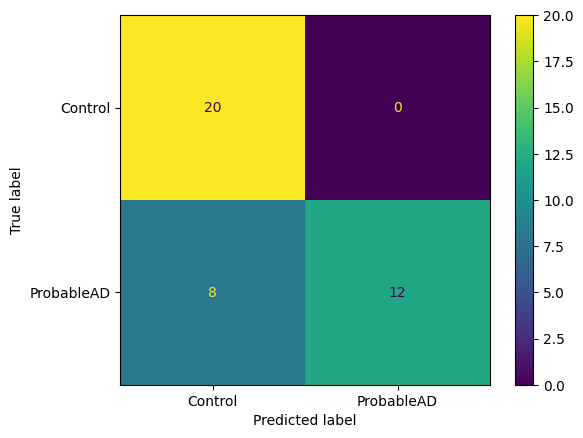

In [13]:
from sklearn.naive_bayes import BernoulliNB

if Load:
    clf = load('./model/BernoulliNB.joblib')
else:
    clf = BernoulliNB()
    for i in range(11):
        for j in range(0, train_data['X'].shape[0], 100):
            clf.partial_fit(train_data['X'][j:j+100], train_data['y'][j:j+100], classes=['Control','ProbableAD'])
        print(clf.score(train_data['X'], train_data['y']))

if Save:
    dump(clf, './model/BernoulliNB.joblib')

print(clf.score(test_data['X'], test_data['y']))
cm = confusion_matrix(test_data['y'], clf.predict(test_data['X']), labels=['Control','ProbableAD'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control','ProbableAD'])
disp.plot()
plt.show()

0.575
0.5
0.85
0.825
0.575
0.8
0.775
0.7
0.825
0.825
0.825
0.825


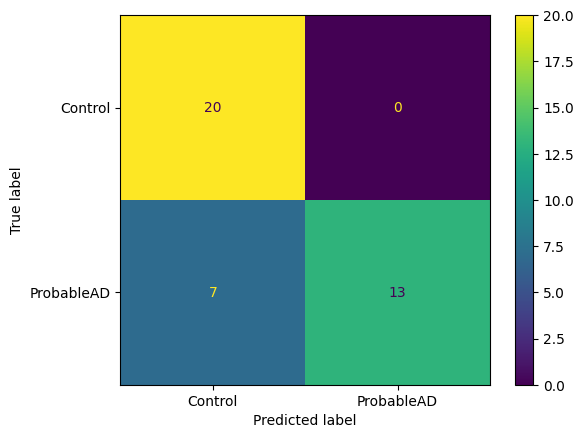

In [12]:
from sklearn.linear_model import Perceptron
# clf = Perceptron(penalty="elasticnet", n_iter_no_change=10, n_jobs=-1, fit_intercept=True, verbose=2)

if Load:
    clf = load('./model/Perceptron.joblib')
else:
    clf = Perceptron(penalty="elasticnet", n_jobs=-1, fit_intercept=True)
    # clf = GridSearchCV(
    #     clf, {
    #         'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    #         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    #         'eta0': [0.1, 0.3],
    #     }, n_jobs=-1, verbose=1, cv=2, scoring='f1_macro', refit=True
    # )
    # clf.fit(train_data['X'], train_data['y'])
    for j in range(11):
        clf.partial_fit(train_data['X'], train_data['y'], classes=['Control','ProbableAD'])
        print(clf.score(test_data['X'], test_data['y']))
        # clf.fit(train_data['X'], train_data['y'])
if Save:
    dump(clf, './model/Perceptron.joblib')
    
print(clf.score(test_data['X'], test_data['y']))
cm = confusion_matrix(test_data['y'], clf.predict(test_data['X']), labels=['Control','ProbableAD'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control','ProbableAD'])
disp.plot()
plt.show()

0.525
0.5
0.65
0.6
0.8
0.4
0.525
0.55
0.85
0.725
0.75
0.75


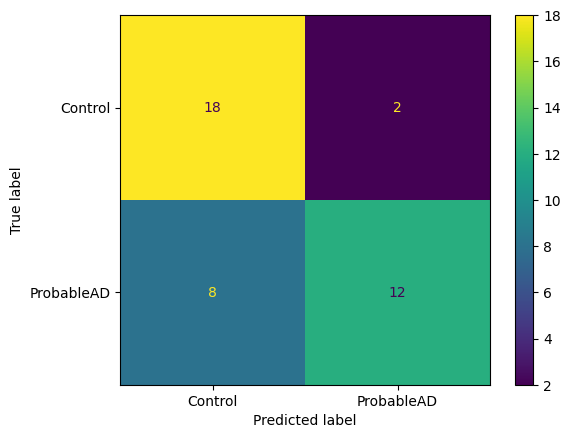

In [6]:
from sklearn.linear_model import SGDClassifier
# clf = SGDClassifier(loss="hinge", penalty="elasticnet", n_jobs=-1, fit_intercept=True, verbose=2)

if Load:
    clf = load('./model/SGDClassifier.joblib')
else:
    clf = SGDClassifier(loss="hinge", penalty="elasticnet", n_jobs=-1, fit_intercept=True)
    for j in range(11):
        clf.partial_fit(train_data['X'], train_data['y'], classes=['Control','ProbableAD'])
        print(clf.score(test_data['X'], test_data['y']))
    
if Save:
    dump(clf, './model/SGDClassifier.joblib')

print(clf.score(test_data['X'], test_data['y']))
cm = confusion_matrix(test_data['y'], clf.predict(test_data['X']), labels=['Control','ProbableAD'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control','ProbableAD'])
disp.plot()
plt.show()

In [ ]:
# list all wrong prediction
# for i in range(len(test_data['y'])):
#     if test_data['y'][i] != clf.predict([test_data['X'][i]]):
#         print(i, test_data['y'][i], clf.predict(test_data['X'])[i])
#         print(test_data['X'][i])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.0s finished


0.675


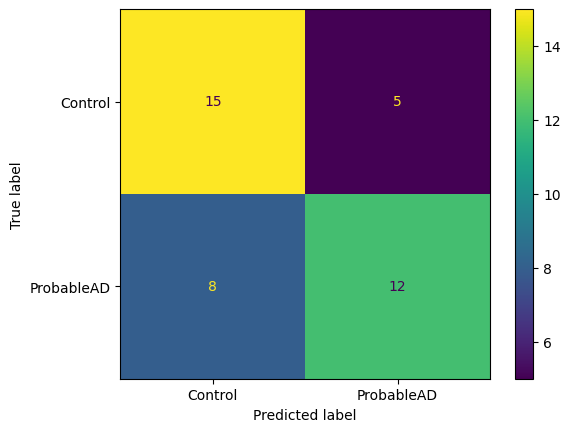

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

if Load:
    clf = load('./model/LogisticRegression.joblib')
else:
    # clf = GridSearchCV(
    #     LogisticRegression(),
    #     {
    #         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    #         # 'penalty': ['l1', 'l2', 'elasticnet', 'none']
    #     },
    #     n_jobs=-1, verbose=1, scoring='f1_macro', refit=True
    # )
    clf = LogisticRegression(solver='newton-cg',max_iter=1000, verbose=1, n_jobs=-1)
    clf.fit(train_data['X'], train_data['y'])
    # print(clf.score(test_data['X'], test_data['y']))
    # clf = LogisticRegression(solver='lbfgs',max_iter=1000, verbose=1, n_jobs=-1)
    # clf.fit(train_data['X'], train_data['y'])
    # print(clf.score(test_data['X'], test_data['y']))
    # clf = LogisticRegression(solver='liblinear',max_iter=1000, verbose=1, n_jobs=-1)
    # clf.fit(train_data['X'], train_data['y'])
    # print(clf.score(test_data['X'], test_data['y']))
    # clf = LogisticRegression(solver='newton-cg',max_iter=1000, verbose=1, n_jobs=-1)
    # clf.fit(train_data['X'], train_data['y'])
    # print(clf.score(test_data['X'], test_data['y']))

if Save:
    dump(clf, './model/LogisticRegression.joblib')

print(clf.score(test_data['X'], test_data['y']))
cm = confusion_matrix(test_data['y'], clf.predict(test_data['X']), labels=['Control','ProbableAD'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control','ProbableAD'])
disp.plot()
plt.show()

[LibSVM]0.65


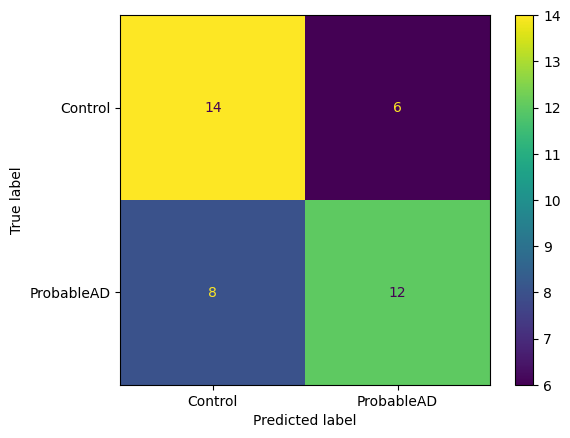

In [9]:
from sklearn import svm

if Load:
    clf = load('./model/SVC.joblib')
else:
    clf = svm.SVC(kernel='linear', verbose=1, max_iter=1000)
    clf.fit(train_data['X'], train_data['y'])

if Save:
    dump(clf, './model/SVC.joblib')

print(clf.score(test_data['X'], test_data['y']))
cm = confusion_matrix(test_data['y'], clf.predict(test_data['X']), labels=['Control','ProbableAD'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control','ProbableAD'])
disp.plot()
plt.show()

0.525


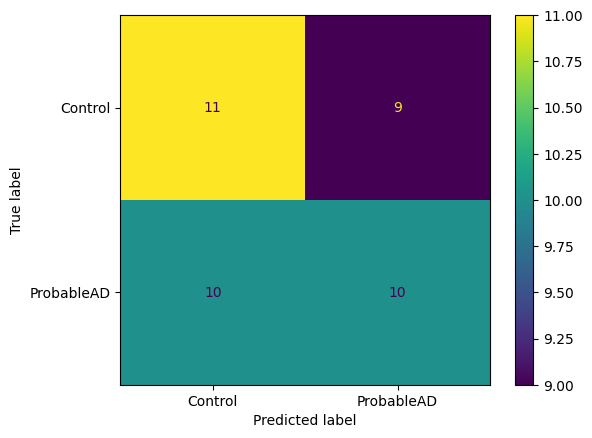

In [10]:
from sklearn.tree import DecisionTreeClassifier

if Load:
    clf = load('./model/DecisionTreeClassifier.joblib')
else:
    clf = DecisionTreeClassifier()
    clf.fit(train_data['X'], train_data['y'])

if Save:
    dump(clf, './model/DecisionTreeClassifier.joblib')

print(clf.score(test_data['X'], test_data['y']))
cm = confusion_matrix(test_data['y'], clf.predict(test_data['X']), labels=['Control','ProbableAD'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control','ProbableAD'])
disp.plot()
plt.show()

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

if Load:
    clf = load('./model/RandomForestClassifier.joblib')
else:
    # clf = RandomForestClassifier(n_estimators=1000, verbose=1, n_jobs=-1)
    random_grid = {
        'n_estimators': [ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,2378, 2585, 2792, 3000],
        'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],
        'min_samples_split': [1, 2, 5, 10, 15, 20, 30],
        'min_samples_leaf': [1, 2, 3, 4],
        'bootstrap': [True, False],
        'criterion': ['gini', 'entropy']
    }
    clf = RandomizedSearchCV(
        estimator=RandomForestClassifier(),
        param_distributions=random_grid,
        n_iter=100,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1,
        scoring='f1_macro'
    )
    clf.fit(train_data['X'], train_data['y'])
    print(clf.best_estimator_)

if Save:
    dump(clf, './model/RandomForestClassifier.joblib')

print(clf.score(test_data['X'], test_data['y']))
cm = confusion_matrix(test_data['y'], clf.predict(test_data['X']), labels=['Control','ProbableAD'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control','ProbableAD'])
disp.plot()
plt.show()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\Tawatwee\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.825


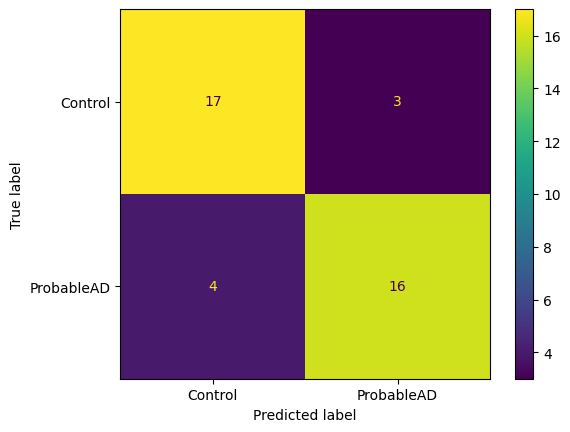

In [4]:
from sklearn.neural_network import MLPClassifier

if Load:
    clf = load('./model/MLPClassifier.joblib')
else:
    clf = MLPClassifier(solver='lbfgs', max_iter=20, verbose=1,shuffle=True)
    clf.fit(train_data['X'], train_data['y'])

if Save:
    dump(clf, './model/MLPClassifier.joblib')

print(clf.score(test_data['X'], test_data['y']))
cm = confusion_matrix(test_data['y'], clf.predict(test_data['X']), labels=['Control','ProbableAD'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Control','ProbableAD'])
disp.plot()
plt.show()